### Perform maximum likelihood estimation using the principle of Delta-map to calculate a clean map.

In [1]:
using NPZ
using PyPlot, Statistics, Distributions
include("../src/function/ml_delta_map.jl")
include("../src/function/set_data_model.jl")
# set parameters
freq_bands = [40, 60, 140]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140]
#freq_bands = [140, 235, 280, 402]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140, 166, 195, 235, 280, 337, 402]; #GHz
which_model = "s1"
r_input = 0.01
seed = 2
nside = 4
num_I = 2  
noise = true
cov_mat_scal = npzread("../covariance_matrix/smoothing_cov_mat_scal.npy")
cov_mat_tens = npzread("../covariance_matrix/smoothing_cov_mat_tens.npy")
mask_path = "../mask_p06_Nside4.v2.fits"
mask_true = hp.read_map(mask_path)
mask = hp.read_map(mask_path).*0 .+1;
N⁻¹_set = Matrix{Float64}[]  
m_set = Vector{Float64}[]  
r_est = 0.5

# definite SetParams and FitParams struct
set_params = SetParams(freq_bands, which_model, r_input, seed, nside, num_I, cov_mat_scal, cov_mat_tens, mask, m_set, N⁻¹_set)
fit_params = FitParams(-3, 1.5, 20.1, r_est);

In [2]:
set_num_I_ml!(set_params)
set_N⁻¹_ml!(set_params, noise)
set_m_vec_ml!(set_params, noise);
clean_Q, clean_U = calc_clean_map_cmb_ml(set_params, fit_params);
clean_cl = hp.anafast([clean_Q, clean_Q, clean_U], lmax=2*nside);

sys:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 


In [3]:
base_dir_cmb = "../map_file/cmb_map/"
nside_str = "_nside_$(set_params.nside)"
r_name = "r_"
r_n = string(set_params.r_input)
seed_name = "_seed_"
seed_n = string(set_params.seed)
GHz = "_GHz"
Cmb_name = joinpath(base_dir_cmb, "$(r_name)$(r_n)$(nside_str)$(seed_name)$(seed_n)")
cmb_data_Q = hp.read_map(Cmb_name, field=1)
cmb_data_U = hp.read_map(Cmb_name, field=2);
input_fwhm = 2200 * (4/nside)^2
smoothed_cmb = smoothing_map_fwhm([cmb_data_Q,cmb_data_Q,cmb_data_U], input_fwhm, set_params.nside);
smoothed_Q, smoothed_U = smoothed_cmb[2, :], smoothed_cmb[3, :];
smoothed_cmb_cl  = hp.anafast([smoothed_Q, smoothed_Q, smoothed_U], lmax=2*nside);
cmb_cl = hp.anafast([cmb_data_Q, cmb_data_Q, cmb_data_U], lmax=2*nside);

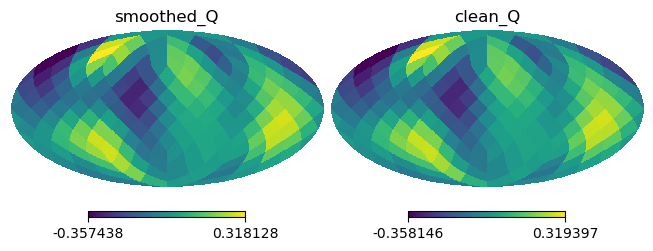

In [4]:
hp.mollview(smoothed_Q, title="smoothed_Q", sub=(1,2,1), hold=false)
hp.mollview(clean_Q, title="clean_Q", sub=(1,2,2), hold=false)

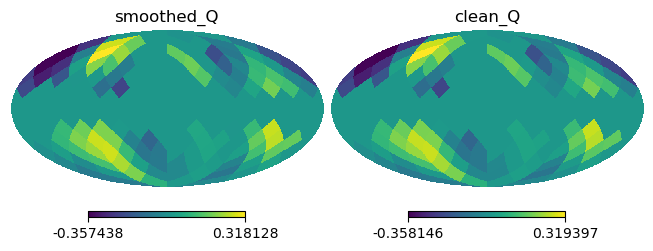

In [5]:
hp.mollview(smoothed_Q.*mask_true, title="smoothed_Q", sub=(1,2,1), hold=false)
hp.mollview(clean_Q.*mask_true, title="clean_Q", sub=(1,2,2), hold=false)

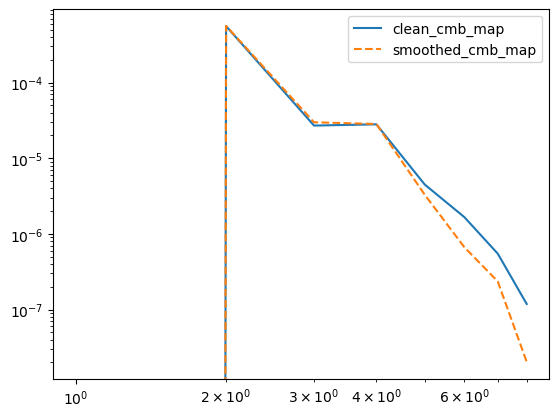

PyObject <matplotlib.legend.Legend object at 0x32aeb7050>

In [6]:
plt.loglog(clean_cl[3, :], label="clean_cmb_map")
plt.loglog(smoothed_cmb_cl[3, :], label="smoothed_cmb_map", linestyle="dashed")
plt.legend()

### Estimate parameters by iteratively performing maximum likelihood estimation using the calculated clean map.

In [1]:
using NPZ
using PyPlot, Statistics, Distributions
# test function
include("../src/function/ml_delta_map.jl")
include("../src/function/r_estimate_ml.jl")
include("../src/function/set_data_model.jl")
# set parameters
freq_bands = [40, 60, 140]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140, 166, 195, 235, 280, 337, 402]; #GHz
which_model = "s1"
r_input = 0.01
seed = 2
nside = 4
num_I = 2  
noise = true
cov_mat_scal = npzread("../covariance_matrix/smoothing_cov_mat_scal.npy")
cov_mat_tens = npzread("../covariance_matrix/smoothing_cov_mat_tens.npy")
mask_path = "../mask_p06_Nside4.v2.fits"
mask = hp.read_map(mask_path);
N⁻¹_set = Matrix{Float64}[]  
m_set = Vector{Float64}[]  
r_est = 0.5

# definite SetParams and FitParams struct
set_params = SetParams(freq_bands, which_model, r_input, seed, nside, num_I, cov_mat_scal, cov_mat_tens, mask, m_set, N⁻¹_set)
fit_params = FitParams(-3, 1.5, 20.1, r_est);

In [2]:
set_num_I_ml!(set_params)
set_N⁻¹_ml!(set_params, noise)
set_m_vec_ml!(set_params, noise);

sys:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 


In [3]:
iterative_minimization_pix_based(set_params, fit_params, noise)

Iteration 1: r = 0.00993461006917451, Likelihood = -2138.181367216467
delta_like = 1.0000002138181368e10
delta_r = 0.4900653899308255
Iteration 2: r = 0.007354330617140248, Likelihood = -2133.5213741541297
delta_like = 4.659993062337435
delta_r = 0.002580279452034262
Iteration 3: r = 0.007356219222374061, Likelihood = -2131.918962014372
delta_like = 1.6024121397576891
delta_r = 1.8886052338129566e-6
Iteration 4: r = 0.007356236379062742, Likelihood = -2131.9005657499906
delta_like = 0.0183962643814084
delta_r = 1.715668868085274e-8
Iteration 5: r = 0.007356236379062742, Likelihood = -2131.900614962532
delta_like = 4.9212541398446774e-5
delta_r = 0.0


(FitParams(-3.008092438087919, 1.5, 20.1, 0.007356236379062742), [1, 2, 3, 4, 5], [0.00993461006917451, 0.007354330617140248, 0.007356219222374061, 0.007356236379062742, 0.007356236379062742], [-2138.181367216467, -2133.5213741541297, -2131.918962014372, -2131.9005657499906, -2131.900614962532])

In [4]:
r_dis, beta_s_dis, _, _ = estimate_r_distribution_pix_based(set_params, fit_params, 10, noise)

Iteration 1: r = 0.005119781430411363, Likelihood = -2174.438462583986
delta_like = 1.0000002174438463e10
delta_r = 0.0022364549486513785
Iteration 2: r = 0.005113446106060959, Likelihood = -2171.547479411601
delta_like = 2.8909831723849493
delta_r = 6.335324350403848e-6
Iteration 3: r = 0.005113502474833276, Likelihood = -2171.5350882737725
delta_like = 0.012391137828672072
delta_r = 5.636877231651738e-8
Iteration 4: r = 0.005113502474833276, Likelihood = -2171.5350882737725
delta_like = 0.0
delta_r = 0.0
Iteration 1: r = 0.007356236379062742, Likelihood = -2131.900614962532
delta_like = 1.0000002131900616e10
delta_r = 0.0
Iteration 2: r = 0.007356236379062742, Likelihood = -2131.900614962532
delta_like = 0.0
delta_r = 0.0
Iteration 1: r = 0.005586070083645367, Likelihood = -2155.0649840981346
delta_like = 1.0000002155064983e10
delta_r = 0.0017701662954173747
Iteration 2: r = 0.005623040824914771, Likelihood = -2153.8090905896815
delta_like = 1.2558935084530276
delta_r = 3.69707412694

(Any[0.005113502474833276, 0.007356236379062742, 0.0056215250576423514, 0.01083688488054163, 0.019434440302954215, 0.006291833391946389, 0.009074234075854004, 0.012326064106648105, 0.006844496908419984, 0.010740816826295074], Any[-3.0508959941501645, -3.008092438087919, -2.825584209629421, -2.9543565520954416, -3.002660841926372, -2.750628340564627, -3.0070537772514916, -2.8628720079664736, -3.0822080983876896, -2.852537268838466], Any[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5], Any[20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1])

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


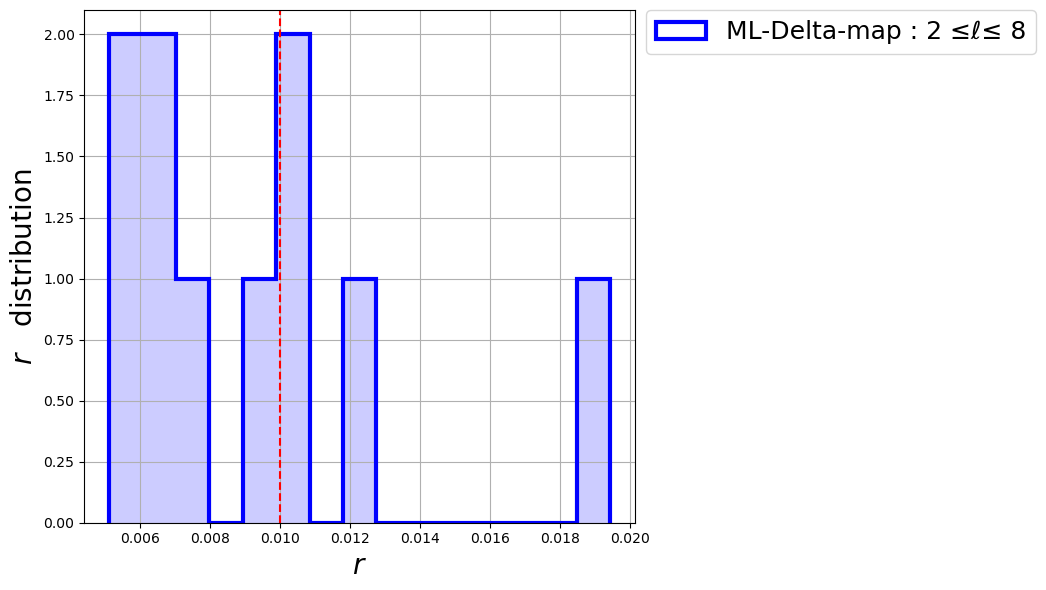

In [5]:
figure(figsize=(8, 6))
hist(r_dis, bins=15, alpha=0.2, color="blue", histtype="stepfilled")
hist(r_dis, bins=15, alpha=1., edgecolor="blue", label="ML-Delta-map : 2 ≤ℓ≤ 8", histtype="step", linewidth=3)
axvline(x=r_input, color="red", linestyle="--")
xlabel(L"$r$", fontsize=20)
ylabel(L"$r\quad$distribution", fontsize=20)  
plt.grid(true)
legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize="18")
tight_layout()
subplots_adjust(right=0.8)
show()

In [6]:
println(mean(r_dis))
println(std(r_dis))
println(mean(beta_s_dis))
println(std(beta_s_dis))

0.009364003440419776
0.004297630310373072
-2.9396889528898065
0.10971500105616003
